# Audio Moderator V.2

This project aims to translate Chinese audio to English text to assist in content moderation and foreign language audio/video sharing. This version so far includes the seq2seq machine translation model with Attention.

## Set-up and Data Cleaning

In [16]:


import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
import jieba
import numpy as np
#!pip install jieba --upgrade
#from mafan import simplify
#from langconv import *

 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs
 
# clean a list of lines
def clean_pairs(lines):
	english = []
	chinese = []
	for pair in lines:
		#eng = pair[0].split(' ')
		eng = pair[0].lower()
		eng = re.sub(r'[.,?!]','',pair[0])
		chi1 = jieba.cut(pair[1], cut_all=False)
		chi2 = ' '.join(chi1)
		chi2 = re.sub(r'[^\w\s]', '', chi2)
		chi2 = chi2.rstrip()

		english.append(eng)
		chinese.append(chi2)
	return english, chinese
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
print('done')

done


## Cleaning and Saving the Data

In [17]:

import chinese_converter

# load dataset
filename = 'cmn.txt'
doc = load_doc(filename)
# split into english-chinese pairs
pairs = to_pairs(doc)
# clean sentences
eng_clean_pairs, chi_clean_pairs = clean_pairs(pairs)


print(pairs[0])
print(eng_clean_pairs[10])
print(chi_clean_pairs[100])

Hi


In [19]:
chi_cleaner_pairs = [chinese_converter.to_simplified(i) for i in chi_clean_pairs]

clean_pairs = [[i, j] for i, j in zip(eng_clean_pairs,chi_cleaner_pairs)]

# spot check

print(chi_cleaner_pairs[20:25])
print(clean_pairs[:5])

# for i in range(15):
# 	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

['Hi.', '嗨。', 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)']
Got it
我 迷失 了
[['Hi', '嗨'], ['Hi', '你好'], ['Run', '你 用 跑 的'], ['Wait', '等等'], ['Wait', '等 一下']]
['我们 来 试试', '为什么 是 我', '去 问 汤姆', '好棒', '冷静 点']


In [20]:
for i in range(20):
	print('[%s] => [%s]' % (clean_pairs[i][0], clean_pairs[i][1]))

[Hi] => [嗨]
[Hi] => [你好]
[Run] => [你 用 跑 的]
[Wait] => [等等]
[Wait] => [等 一下]
[Hello] => [你好]
[I try] => [让 我 来]
[I won] => [我 赢 了]
[Oh no] => [不会 吧]
[Cheers] => [干杯]
[Got it] => [你 懂 了 吗]
[He ran] => [他 跑 了]
[Hop in] => [跳进来]
[I quit] => [我 退出]
[I'm OK] => [我 没事]
[Listen] => [听 着]
[No way] => [不 可能]
[No way] => [没门]
[Really] => [你 确定]
[Try it] => [试试 吧]


In [21]:
# save clean pairs to file
save_clean_data(clean_pairs, 'english-chinese.pkl')

Saved: english-chinese.pkl


In [22]:

from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
print('done')

done


## Split Clean Data

In [23]:
# load dataset
raw_dataset = load_clean_sentences('english-chinese.pkl')
 
# reduce dataset size
n_sentences = 19000
dataset = raw_dataset[:n_sentences]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:17000], dataset[17000:]
# save
save_clean_data(dataset, 'english-chinese-both.pkl')
save_clean_data(train, 'english-chinese-train.pkl')
save_clean_data(test, 'english-chinese-test.pkl')

print(len(raw_dataset))
print(raw_dataset[0])
print(dataset[0])
print(train[0])
print(test[0])

Saved: english-chinese-both.pkl
Saved: english-chinese-train.pkl
Saved: english-chinese-test.pkl
22075
['Hi', '嗨']
['He earned as much money as possible', '他 能 赚 多少 就 赚 多少']
['He earned as much money as possible', '他 能 赚 多少 就 赚 多少']
['Please knock on the door', '请 敲门']


## Tokenize Clean Data and Set-up for LSTM Model

In [24]:
from pickle import load
from numpy import array
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, GlobalMaxPooling1D, SpatialDropout1D
from attention_decoder import AttentionDecoder
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(Dropout(0.5))
	# model.add(LSTM(n_units))
	# model.add(Dropout(0.5))
	model.add(RepeatVector(tar_timesteps))
	#model.add(LSTM(n_units, return_sequences=True))
	# model.add(Dropout(0.5))
	model.add(AttentionDecoder(n_units, tar_vocab))
	#model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# # define the encoder-decoder with attention model
# def attention_model(n_timesteps_in, n_features):
# 	model = Sequential()
# 	model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
# 	model.add(AttentionDecoder(150, n_features))
# 	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 	return model

print('done')

Using TensorFlow backend.


done


## Explore Some Features of the Dataset

In [25]:
 
# load datasets
dataset = load_clean_sentences('english-chinese-both.pkl')
train = load_clean_sentences('english-chinese-train.pkl')
test = load_clean_sentences('english-chinese-test.pkl')

print(dataset[:2])
print(train[:2])
print(test[:2])
print(len(dataset))
print(len(train))
print(len(test))
eng_data = [i[0] for i in dataset]
chi_data = [i[1] for i in dataset]
eng_train = [i[0] for i in train]
chi_train = [i[1] for i in train]
eng_test = [i[0] for i in test]
chi_test = [i[1] for i in test]

print(eng_data[:5])
print(chi_data[:5])

[['He earned as much money as possible', '他 能 赚 多少 就 赚 多少'], ['He knows how to play baseball', '他 知道 怎么 玩 棒球']]
[['He earned as much money as possible', '他 能 赚 多少 就 赚 多少'], ['He knows how to play baseball', '他 知道 怎么 玩 棒球']]
[['Please knock on the door', '请 敲门'], ['I want to talk to your boss', '我 想 跟 你 老板 谈']]
19000
17000
2000
['He earned as much money as possible', 'He knows how to play baseball', 'Is there anything that I should not eat', 'I have no knife to cut with', 'The capital of Brazil is Brasilia']
['他 能 赚 多少 就 赚 多少', '他 知道 怎么 玩 棒球', '有 什么 东西 是 我 不该 吃 的 吗', '我 没 有 刀子 可用 来切', '巴西 的 首都 是 巴西利亚']


In [26]:
import numpy as np

# prepare english tokenizer
eng_tokenizer = create_tokenizer(eng_data)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(eng_data)
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare chinese tokenizer
chi_tokenizer = create_tokenizer(chi_data)
chi_vocab_size = len(chi_tokenizer.word_index) + 1
chi_length = max_length(chi_data)
print('Chinese Vocabulary Size: %d' % chi_vocab_size)
print('Chinese Max Length: %d' % (chi_length))
#print(eng_tokenizer[0])
#print(chi_tokenizer[0])

eng_data_lengths = [] 
chi_data_lengths = [] 

for i in eng_data: 
      eng_data_lengths.append(len(i.split())) 

for i in chi_data: 
      chi_data_lengths.append(len(i.split())) 


eng_avg_sents = (sum(eng_data_lengths))/(len(eng_data))
chi_avg_sents = (sum(chi_data_lengths))/(len(chi_data))

print('Average English sentence length: ', eng_avg_sents)
print('Average Chinese sentence length: ', chi_avg_sents)

English Vocabulary Size: 5449
English Max Length: 11
Chinese Vocabulary Size: 10396
Chinese Max Length: 16
Average English sentence length:  5.605
Average Chinese sentence length:  5.188473684210527


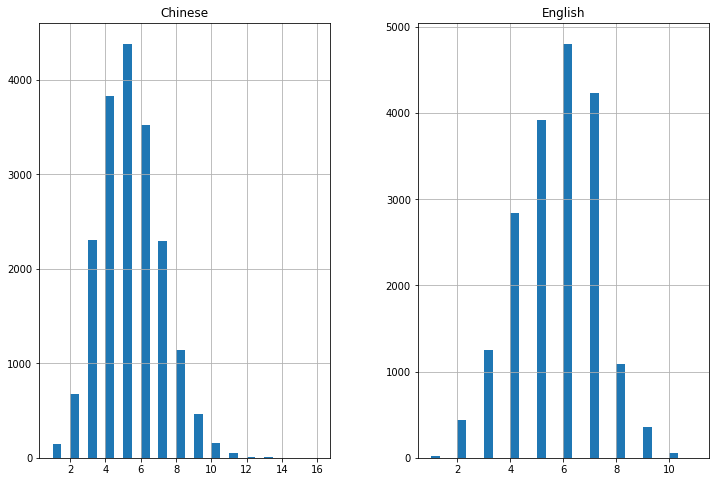

In [27]:
#histograms of sentence lengths

import pandas as pd
import matplotlib.pyplot as plt



length_df = pd.DataFrame({'English':eng_data_lengths, 'Chinese':chi_data_lengths}) 
length_df.hist(bins=30, figsize=(12,8)) 
plt.show()

In [28]:
#tokens that only appear once
eng_single_words = [w for w,c in eng_tokenizer.word_counts.items() if c == 1]
chi_single_words = [w for w,c in chi_tokenizer.word_counts.items() if c == 1]

eng_frequent_words = [w for w,c in eng_tokenizer.word_counts.items() if c > 100]
chi_frequent_words = [w for w,c in chi_tokenizer.word_counts.items() if c > 100]

print('English single words: ', len(eng_single_words))
print(eng_single_words)
print()
print('Chinese single words: ', len(chi_single_words))
print(chi_single_words)
print()
print('English frequent words: ', len(eng_frequent_words))
print(eng_frequent_words)
print()
print('Chinese frequent words: ', len(chi_frequent_words))
print(chi_frequent_words)
print()
print('Percent of single words in English vocab: ', (len(eng_single_words)/eng_vocab_size)*100)
print('Percent of single words in Chinese vocab: ', (len(chi_single_words)/chi_vocab_size)*100)

English single words:  2155
['brasilia', 'reported', 'acquaintance', 'nara', 'miracles', "devil's", 'advocate', 'pleated', 'belt', 'adjoins', 'frequent', 'ridge', 'creature', 'tool', 'eloquent', 'google', 'immigrants', 'tow', 'steak', 'sail', 'bliss', 'fancy', 'pacemaker', 'disagreeing', 'traditions', 'risen', 'opposite', 'tsunami', 'uneasy', 'boats', 'coach', 'selected', 'modifications', 'realized', '1689', 'fares', 'carpentry', 'undercooked', "cookie's", 'shuffle', 'damp', 'impulse', 'germanic', 'marrying', 'decides', 'agreeing', 'kilometers', 'prized', 'possession', 'booked', 'globe', 'hoarse', 'nonstop', 'flight', 'respects', 'homeroom', 'disaster', 'sunflower', 'catching', 'scandal', 'picks', 'significance', 'jesus', 'stopping', 'intruded', 'yield', 'flames', 'presents', 'mastercard', '56', 'russell', 'square', 'border', 'plunged', 'record', 'damaged', 'vegetable', 'considerate', 'effect', 'swarm', 'hornets', 'incredibly', 'lemons', 'campfire', "country's", 'temperate', 'leads', '

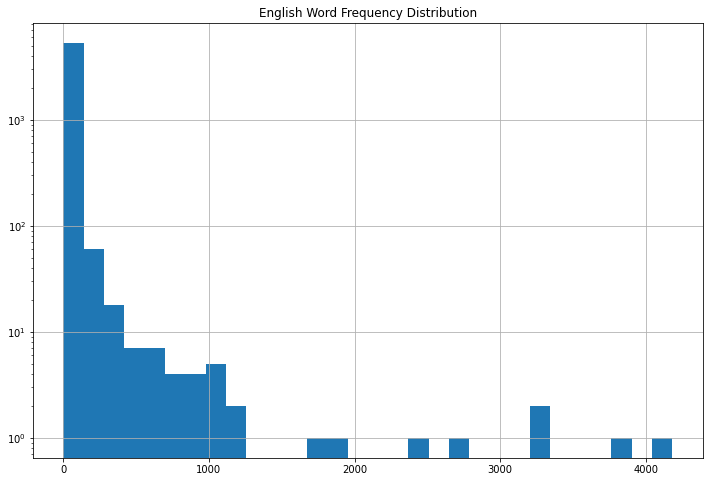

In [29]:
#English distribution of word frequencies
eng_words_unique = [w for w,c in eng_tokenizer.word_counts.items()]
eng_words_counts = [c for w,c in eng_tokenizer.word_counts.items()]
df_eng_frequency = pd.DataFrame(zip(eng_words_unique, eng_words_counts), columns=['words', 'frequency'])
df_eng_frequency['frequency'].hist(bins=30, figsize=(12,8))
plt.yscale('log')
plt.title('English Word Frequency Distribution')
plt.show()

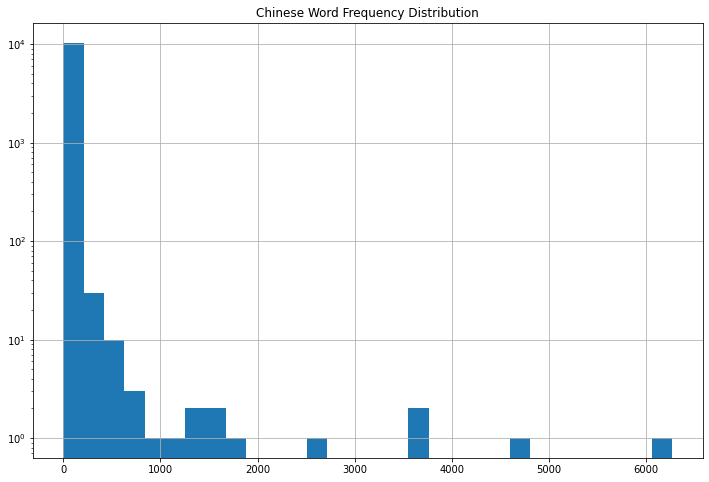

In [30]:
#English distribution of word frequencies
chi_words_unique = [w for w,c in chi_tokenizer.word_counts.items()]
chi_words_counts = [c for w,c in chi_tokenizer.word_counts.items()]
df_chi_frequency = pd.DataFrame(zip(chi_words_unique, chi_words_counts), columns=['words', 'frequency'])
df_chi_frequency['frequency'].hist(bins=30, figsize=(12,8))
plt.yscale('log')
plt.title('Chinese Word Frequency Distribution')
plt.show()

## Encode and Pad Sequences

In [31]:
# prepare training data
trainX = encode_sequences(chi_tokenizer, chi_length, chi_train)
trainY = encode_sequences(eng_tokenizer, eng_length, eng_train)
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(chi_tokenizer, chi_length, chi_test)
testY = encode_sequences(eng_tokenizer, eng_length, eng_test)
testY = encode_output(testY, eng_vocab_size)
 
print(trainX[0])
print(trainY[0])
print(testX[0])
print(testY[0])
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

[   5   46 1461  133   51 1461  133    0    0    0    0    0    0    0
    0    0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[  32 1219    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(17000, 16)
(17000, 11, 5449)
(2000, 16)
(2000, 11, 5449)


## Define and Train Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 80)            831680    
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 11, 80)            0         
_________________________________________________________________
AttentionDecoder (AttentionD (None, 11, 5449)          31934650  
Total params: 32,817,850
Trainable params: 32,817,850
Non-trainable params: 0
_________________________________________________________________
None


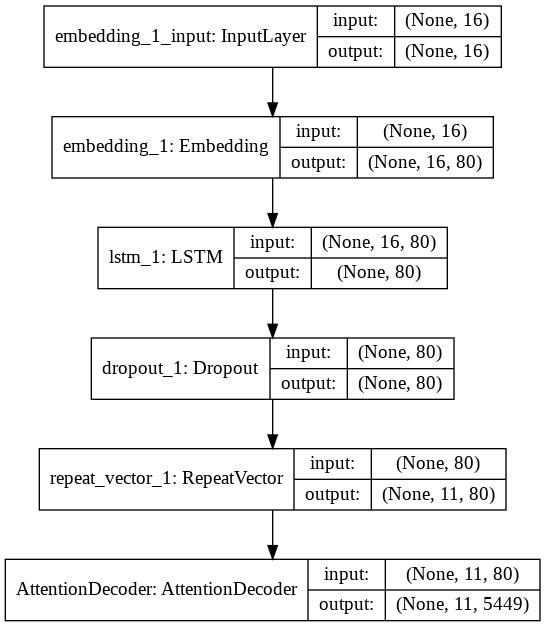

In [32]:
# define model
model = define_model(chi_vocab_size, eng_vocab_size, chi_length, eng_length, 80)
opt = keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [33]:

# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 17000 samples, validate on 2000 samples
Epoch 1/30
 - 40s - loss: 3.6817 - accuracy: 0.5106 - val_loss: 3.1849 - val_accuracy: 0.5288

Epoch 00001: val_loss improved from inf to 3.18490, saving model to model.h5
Epoch 2/30
 - 38s - loss: 3.0988 - accuracy: 0.5304 - val_loss: 3.0330 - val_accuracy: 0.5414

Epoch 00002: val_loss improved from 3.18490 to 3.03297, saving model to model.h5
Epoch 3/30
 - 39s - loss: 2.9086 - accuracy: 0.5467 - val_loss: 2.8934 - val_accuracy: 0.5592

Epoch 00003: val_loss improved from 3.03297 to 2.89339, saving model to model.h5
Epoch 4/30
 - 39s - loss: 2.7288 - accuracy: 0.5636 - val_loss: 2.7791 - val_accuracy: 0.5738

Epoch 00004: val_loss improved from 2.89339 to 2.77913, saving model to model.h5
Epoch 5/30
 - 38s - loss: 2.5537 - accuracy: 0.5778 - val_loss: 2.6712 - val_accuracy: 0.5829

Epoch 00005: val_loss improved from 2.77913 to 2.67120, saving model to model.h5
Epoch 6/30
 - 38s - loss: 2.3991 - accuracy: 0.5880 - val_loss: 2.5706 - va

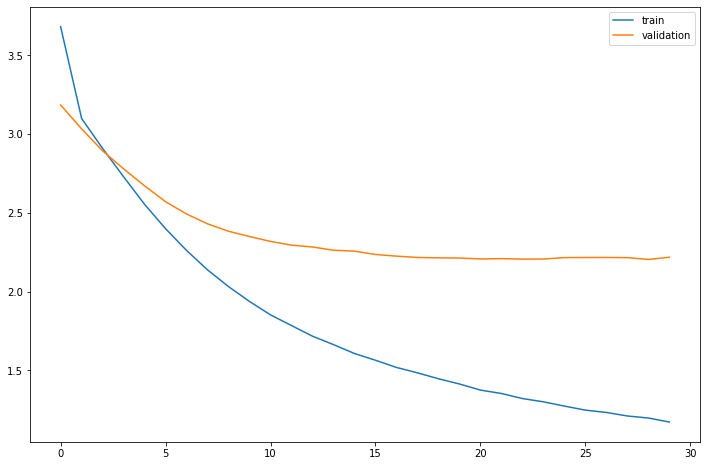

In [34]:
#plot of model training

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

## Functions for Model Evaluation

In [35]:

from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)
 
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
print('done')

done


In [36]:
 
# load datasets
dataset = load_clean_sentences('english-chinese-both.pkl')
train = load_clean_sentences('english-chinese-train.pkl')
test = load_clean_sentences('english-chinese-test.pkl')

eng_data = [i[0] for i in dataset]
chi_data = [i[1] for i in dataset]
eng_train = [i[0] for i in train]
chi_train = [i[1] for i in train]
eng_test = [i[0] for i in test]
chi_test = [i[1] for i in test]

# prepare english tokenizer
eng_tokenizer = create_tokenizer(eng_data)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(eng_data)
# prepare chinese tokenizer
chi_tokenizer = create_tokenizer(chi_data)
chi_vocab_size = len(chi_tokenizer.word_index) + 1
chi_length = max_length(chi_data)
# prepare data
trainX = encode_sequences(chi_tokenizer, chi_length, chi_train)
testX = encode_sequences(chi_tokenizer, chi_length, chi_test)
 
print(dataset[0])
print(train[0])
print(chi_train[1])
print(trainX[0])

['He earned as much money as possible', '他 能 赚 多少 就 赚 多少']
['He earned as much money as possible', '他 能 赚 多少 就 赚 多少']
他 知道 怎么 玩 棒球
[   5   46 1461  133   51 1461  133    0    0    0    0    0    0    0
    0    0]


## Model Evaluation with BLEU Scoring

In [37]:
from attention_decoder import AttentionDecoder

from keras.utils import CustomObjectScope
with CustomObjectScope({'AttentionDecoder': AttentionDecoder}):
    model = load_model('model.h5')

# load model
#model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, [i[:2] for i in train]) 
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, [i[:2] for i in test])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


train
src=[他 能 赚 多少 就 赚 多少], target=[He earned as much money as possible], predicted=[he earned as fast as as]
src=[他 知道 怎么 玩 棒球], target=[He knows how to play baseball], predicted=[he knows how to play baseball]
src=[有 什么 东西 是 我 不该 吃 的 吗], target=[Is there anything that I should not eat], predicted=[is it anything i can do]
src=[我 没 有 刀子 可用 来切], target=[I have no knife to cut with], predicted=[i have no knife with cut]
src=[巴西 的 首都 是 巴西利亚], target=[The capital of Brazil is Brasilia], predicted=[the capital of brazil is brasilia]
src=[他 7 点到 了 火车站], target=[He arrived at the station at seven], predicted=[he arrived at the station at seven]
src=[你 的 父母 有 多 高], target=[How tall are your parents], predicted=[how tall is your parents]
src=[我 曾 希望 在 那里 遇见 你], target=[I had hoped to meet you there], predicted=[i have hoped to there there there]
src=[他们 报告 目击 了 事故], target=[They reported seeing the incident], predicted=[they reported the the incident]
src=[请给 我 菜 单], target=[Please give me th

In [ ]:
#notes

# best score BLEU-1: 0.35, model nodes = 500, also nodes=1500, 10000 samples

#best accuracy: attention decoder, 64 neurons, 0.2 dropout, bleu-1 .37

#attention decoder, 50 neurons, 0.3 dropout, bleu-1 .365

#attention decoder, 32 neurons, 0.3 dropout, bleu-1 .3988

#50 neurons, epochs=30, lr=0.003, dropout=0.4, 18000 sents, train bleu-1=.45, test bleu-1=.249 (could train further)

#60 neurons, epochs=30, lr=0.003, dropout=0.4, 18000 sents, train bleu-1=.484, test bleu-1=.265 (stops training at 25, 66%training accuracy)

#70 neurons, epochs=30, lr=0.003, dropout=0.4, 18000 sents, train bleu-1=.514, test bleu-1=.272 (stops training at 25, 66%training accuracy)

#80 neurons, epochs=30, lr=0.003, dropout=0.5, 18000 sents, train bleu-1=.545, test bleu-1=.293 (could train further, 69.5%training accuracy)

#90 neurons, epochs=30, lr = 0.003, dropout=0.5, 18000 sents, train bleu-1=0.505, test=0.285

#90 neurons, epochs=45, lr = adaptive, dropout=0.6, 18000 sents, train bleu-1=0.404, test=0.243 (can train more)

